# MultiCamera Paper Results Generation and Plotting

In [35]:
import matplotlib.pyplot as plt
%matplotlib notebook
from collections import defaultdict
import os
import json
import pandas as pd
import numpy as np

In [36]:
aspect = 1.3
height = 2.5
# params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (15, 5),
#          'axes.labelsize': 'x-large',
#          'axes.titlesize':'x-large',
#          'xtick.labelsize':'x-large',
#          'ytick.labelsize':'x-large'}

params = {'axes.labelsize': 'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

In [37]:
import sys
sys.path.append("../..") # Adds higher directory to python modules path.

from utilitysimv4 import Camera, InferenceJob, TrainingJob, MultiPeriodSimulator, fair_naive_scheduler, fair_dumb_scheduler, fair_sco_scheduler, fair_random_scheduler, inference_only_scheduler, single_camera_naive, get_optimus_fn, thief_sco_scheduler, single_camera_optimizer, get_tanh_fn, get_linear_fn, get_infer_profile, get_tanh_fn, simulator, thief_scheduler, fair_scheduler

In [38]:
# !!!!!!! CONFIGURE THESE PARAMS !!!!!!!!
dataset = 'cityscapes' #'cityscapes'
pred_mode = 'datadist'# 'datadist'

In [39]:
PROFILE_DIR = '/home/romilb/research/msr/results/profiling/new_profiling/{}/meta/profiles'.format(dataset)
INFERENCE_PROFILE_PATH = '../real_inference_profiles.csv'
INFERENCE_MAX_DEFAULT = 0.25
PLOT_PATH = './camready_plots/'
os.makedirs(PLOT_PATH, exist_ok=True)

In [40]:
l=os.listdir(PROFILE_DIR)
cities=[x.split('.')[0] for x in l]
print(cities)

['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']


In [41]:
all_data = pd.read_csv('data_eval_sensitivity_delta_all_data_{}_{}.csv'.format(dataset, pred_mode))

In [42]:
x=all_data[(all_data['sched']=='thief') & (all_data['res']==4) & (all_data['period']==100) & (all_data['use_oracle']==True)]# & (citywise_data['city']=="phx-21-40")]

In [43]:
tasks = [t for t in x.mean().keys() if "task" in t]

# Plotting

In [44]:
styles = ['^-', 'v-', 'o-']

In [45]:
PERIOD=100
USE_ORACLE_INFO = False
d = all_data
d = d[d['use_oracle'] == USE_ORACLE_INFO]
d = d[d['period'] == PERIOD]
scheds = ['inference_only', 'fair_dumb','thief']
labels = ["No-retrain", "Fair Scheduler", "Ekya"]

In [46]:
# Group data and create overall_mean col
d['type'] = 'time'
plot_data = d.groupby(['sched', 'res', 'city']).mean()
tasks = [x for x in plot_data.columns if "task_" in x]
plot_data['overall_mean'] = plot_data[tasks].mean(axis=1)

In [47]:
scheds = ['thief_0.1', 'thief_0.2', 'thief_0.5', 'thief_1']
labels = [r'$\delta$={}'.format(delta) for delta in [0.1, 0.2, 0.5, 1]]

In [48]:
final_plot_data=plot_data.mean(level=['sched', 'res'])['algo_time'].unstack(0)[scheds]/4
time_data = final_plot_data

In [49]:
final_plot_data_errs = time_data*0.07

<IPython.core.display.Javascript object>


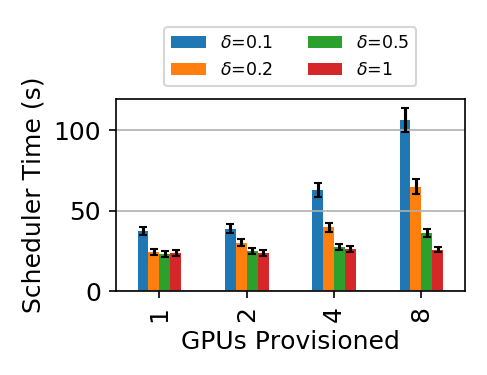

In [50]:
fig = plt.figure(figsize=[aspect*height, height])
ax = plt.gca()
time_data.plot(kind='bar', ax=ax, yerr=final_plot_data_errs,capsize=2)

ax.set_ylabel('Scheduler Time (s)')
ax.set_xlabel('GPUs Provisioned')

lgd = ax.legend(labels, loc="lower center", bbox_to_anchor=(0,1.02,1,0.2), ncol=2, prop={'size': 'small'})
plt.tight_layout()
ax.yaxis.grid(True)
plt.savefig(os.path.join(PLOT_PATH, "sensitivity_delta_runtime_{}.pdf".format(dataset)), bbox_inches='tight')

In [51]:
normalized_time_data = time_data.divide(time_data['thief_0.1'], axis=0)
normalized_time_data['type'] = 'time'

# Plot Delta

In [53]:
# Sigcomm  from scheduler_time_usage_cityscapes_10cam_2.0delay_opt.json
data = {0.1: [[1,2,4,8], np.array([48.2, 63.9, 72.5, 77.3])/100],
       0.2: [[1,2,4,8], np.array([46.4, 60.9, 70.9, 75.7])/100],
       0.5: [[1,2,4,8], np.array([43.1, 58.8, 69.1, 72.4])/100],
       1: [[1,2,4,8], np.array([38.8, 52.4, 68.5, 70.3])/100]}
normalize_mult = (9.4/200)*100
acc_data=pd.DataFrame()
for delta, vals in data.items():
    acc_data['res'] = vals[0]
    acc_data["thief_{}".format(delta)] = vals[1]
acc_data=acc_data.set_index(['res'])
acc_data.columns.name = 'sched'
acc_data['type'] = 'acc'

In [54]:
x=pd.concat([normalized_time_data, acc_data])

In [55]:
x=x.groupby(['res', 'type']).mean()

In [56]:
x

sched     thief_0.1  thief_0.2  thief_0.5   thief_1
res type                                           
1   acc       0.482   0.464000   0.431000  0.388000
    time      1.000   0.654695   0.619569  0.635985
2   acc       0.639   0.609000   0.588000  0.524000
    time      1.000   0.774189   0.646991  0.610387
4   acc       0.725   0.709000   0.691000  0.685000
    time      1.000   0.630986   0.435390  0.415971
8   acc       0.773   0.757000   0.724000  0.703000
    time      1.000   0.610282   0.337877  0.242782

In [57]:
x.loc[res, 'acc'].loc['thief_0.1']

0.725

<IPython.core.display.Javascript object>


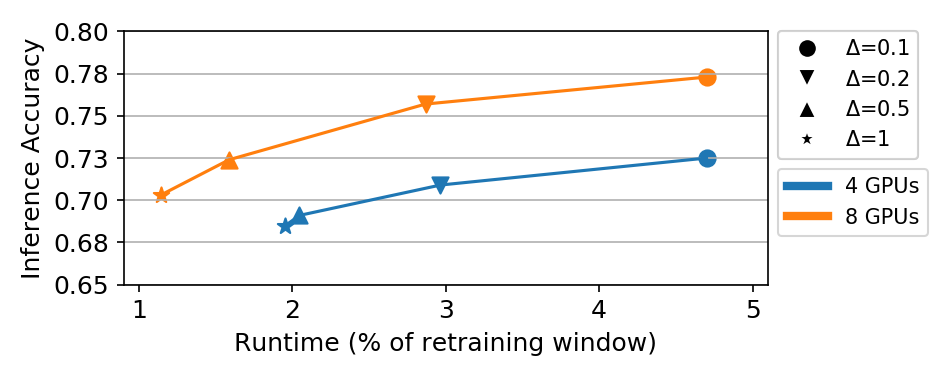

In [60]:
from matplotlib.lines import Line2D
fig = plt.figure(figsize=[aspect*height*1.3*1.5, height*1])
ax = plt.gca()
markers = ['o', 'v', '^', '*']
colors = ['C0', 'C1', 'C2', 'C3']

delta_vals = [0.1, 0.2, 0.5, 1]
res_vals = [4,8]

for i, res in enumerate(res_vals):
    acc_data = x.loc[res, 'acc']
    time_data = x.loc[res, 'time']
    for j, delta in enumerate(delta_vals):
        acc = acc_data.loc['thief_{}'.format(delta)]
        t = time_data.loc['thief_{}'.format(delta)]*normalize_mult
        plt.scatter(t,acc, color=colors[i], marker=markers[j], s=60)
    ax.plot(time_data*normalize_mult, acc_data, label = r'res={}'.format(res), color=colors[i])
    
ax.legend()
ax.set_xlabel('Runtime (% of retraining window)')
ax.set_ylabel('Inference Accuracy')

# y_tick_range = np.arange(0.4,0.9,0.1)
# ax.set_yticks(y_tick_range)
# ax.set_yticklabels(["{:.1f}".format(x) for x in y_tick_range])

x_tick_range = np.arange(0.65,0.8,0.025)
ax.set_yticks(x_tick_range)
ax.set_yticklabels(["{:.2f}".format(x) for x in x_tick_range])

ax.set_xlim([0.9, 5.1])

ax.yaxis.grid(True)

# Plot the baseline:
#ax.axhline(y=0.6825, ls='--', color='C2', alpha=0.7)


lines = [Line2D([0], [0], color=c, lw=4) for c in colors]
scatters = [Line2D([0], [0], marker=m, color='w', label='Scatter',
                          markerfacecolor='black', markersize=9) for m in markers]
baselines = [Line2D([0], [0], ls='--', color='C2', alpha=0.7, lw=2)]

legend1 = ax.legend(lines, ['{} GPUs'.format(r) for r in res_vals], loc='center left', bbox_to_anchor=(1, 0.325))
legend2 = ax.legend(scatters, [r'$\Delta$={}'.format(i) for i in delta_vals], loc='center left', bbox_to_anchor=(1, 0.75))
#legend3 = ax.legend(baselines, ['No-retrain'], loc='center left', bbox_to_anchor=(1, 0.07))
ax.add_artist(legend1)
ax.add_artist(legend2)

plt.tight_layout()

plt.savefig(os.path.join(PLOT_PATH, "sensitivity_delta_acc_runtime_{}_48gpu.pdf".format(dataset)), bbox_inches='tight')

In [93]:
PLOT_PATH

'./camready_plots/'

In [313]:
x.query('res==1')

sched,thief_0.1,thief_0.2,thief_0.5,thief_1,type
res,,,,,
1,1.000,0.654695,0.619569,0.635985,time
1,0.482,0.464000,0.431000,0.388000,acc


In [311]:
for i, delta in enumerate(x):
    x=data[delta][0]
    y=data[delta][1]
    ax.plot(x,y, marker=markers[i], label = r'$\delta$={}'.format(delta))

KeyError: 'thief_0.1'

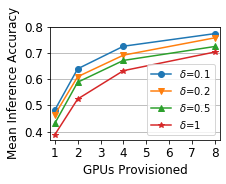

In [72]:
fig = plt.figure(figsize=[aspect*height, height])
ax = plt.gca()
markers = ['o', 'v', '^', '*'] 
for i, delta in enumerate(data):
    x=data[delta][0]
    y=data[delta][1]
    ax.plot(x,y, marker=markers[i], label = r'$\delta$={}'.format(delta))
ax.legend()
ax.set_ylabel('Mean Inference Accuracy')
ax.set_xlabel('GPUs Provisioned')

y_tick_range = np.arange(0.4,0.9,0.1)
ax.set_yticks(y_tick_range)
ax.set_yticklabels(["{:.1f}".format(x) for x in y_tick_range])

x_tick_range = range(1,9)
ax.set_xticks(x_tick_range)
ax.set_xticks(x_tick_range)
ax.set_xticklabels(["{:d}".format(x) for x in x_tick_range])
#ax.set_xticklabels([1, 2, '',4, '', '', '', 8])
ax.set_xlim([0.8, 8.2])

plt.tight_layout()
ax.yaxis.grid(True)
plt.savefig(os.path.join(PLOT_PATH, "sensitivity_delta_{}.pdf".format(dataset)), bbox_inches='tight')

In [16]:
mean_acc_data['thief'] - mean_acc_data['fair_dumb']

res
1    0.176292
2    0.159375
4    0.081417
8    0.050456
dtype: float64

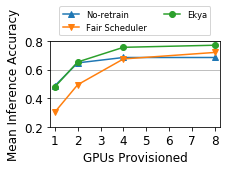

In [17]:
fig = plt.figure(figsize=[aspect*height, height])
ax = plt.gca()
ax = mean_acc_data.plot(y=scheds, kind='line', style=styles, ax=ax,
                       label = labels)#, yerr=std_acc_data)

lgd = ax.legend(loc="lower center", bbox_to_anchor=(0,1.02,1,0.2), ncol=2, prop={'size': 'small'})
ax.set_ylabel('Mean Inference Accuracy')
ax.set_xlabel('GPUs Provisioned')

x_tick_range = range(1,9)
ax.set_xticks(x_tick_range)
ax.set_xticklabels(["{:d}".format(x) for x in x_tick_range])
ax.set_xlim([0.8, 8.2])

y_tick_range = np.arange(0.2,0.9,0.2)
ax.set_yticks(y_tick_range)
ax.set_yticklabels(["{:.1f}".format(x) for x in y_tick_range])
plt.tight_layout()
ax.yaxis.grid(True)
#plt.savefig(os.path.join(PLOT_PATH, "multicam_acc_vs_res_{}.pdf".format(dataset)), bbox_inches='tight')

In [18]:
std_acc_data

sched,fair_dumb,fair_sco,inference_only,thief
res,,,,
1,0.054353,0.059064,0.087433,0.150332
2,0.090660,0.080185,0.116371,0.108023
4,0.114149,0.099437,0.123144,0.079248
8,0.100133,0.092010,0.123144,0.076799


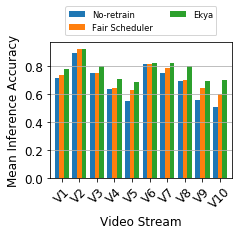

In [19]:
NUM_RES = 8
per_city_data = plot_data.query('res == {}'.format(NUM_RES))[tasks].mean(axis=1).mean(level=['sched', 'city']).unstack(level=0)
std_acc_data = plot_data.query('res == {}'.format(NUM_RES))[tasks].std(axis=1).mean(level=['sched', 'city']).unstack(level=0)


fig = plt.figure(figsize=[aspect*height, height])
ax = plt.gca()
ax = per_city_data.plot(y=scheds, kind='bar', ax=ax, width=0.8, yerr=std_acc_data,
                       label = labels)
#ax.set_ylim([0.4,1])
ax.set_ylabel('Mean Inference Accuracy')
ax.set_xticklabels(["V{}".format(i) for i in range(1, len(ax.get_xticklabels())+1)], rotation=45, ha='center')
ax.set_xlabel('Video Stream')

lgd = ax.legend(loc="lower center", bbox_to_anchor=(0,1.02,1,0.2), ncol=2, prop={'size': 'small'})

#plt.tight_layout()
ax.yaxis.grid(True)
plt.savefig(os.path.join(PLOT_PATH, "multicam_individual_stream_acc_{}.pdf".format(dataset)), bbox_inches='tight')

# Time Series Plot

In [20]:
NUM_RES = 4
city = 'zurich' if dataset == 'cityscapes' else 'phx-41-60_1'
timeseries_data = plot_data.query('res == {}'.format(NUM_RES)).query('city == \'{}\''.format(city))

In [21]:
d = timeseries_data[tasks].mean(level=['sched']).transpose()
d = d[scheds]

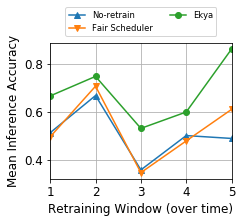

In [22]:
fig = plt.figure(figsize=[aspect*height, height])
ax = plt.gca()

ax = d.plot(y=scheds, style = styles, ax=ax,
            label = labels)
lgd = ax.legend(loc="lower center", bbox_to_anchor=(0,1.02,1,0.2), ncol=2, prop={'size': 'small'})
ax.set_ylabel('Mean Inference Accuracy')
ax.set_xlabel('Retraining Window (over time)')
ax.set_xticks(range(0,5))
ax.set_xticklabels(range(1,6))
ax.grid(True)
plt.savefig(os.path.join(PLOT_PATH, "multicam_taskwise_acc_{}_{}_{}.pdf".format(city, NUM_RES, dataset)), bbox_inches='tight')

# Cost plot

In [34]:
mean_acc_data = plot_data['overall_mean'].mean(level=['sched', 'res', 'city']).unstack(level='res')
#mean_acc_data = mean_acc_data.reorder_levels(['city', 'sched'])

In [37]:
cost_data = mean_acc_data.groupby(['city','sched']).mean()

In [51]:
cost_data.index

MultiIndex(levels=[['aachen', 'bochum', 'bremen', 'cologne', 'darmstadt', 'dusseldorf', 'monchengladbach', 'stuttgart', 'tubingen', 'zurich'], ['fair_dumb', 'fair_sco', 'inference_only', 'thief']],
           codes=[[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9], [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]],
           names=['city', 'sched'])

In [56]:
cost_data[[4,8]]

res                                    4         8
city            sched                             
aachen          fair_dumb       0.697024  0.736173
                fair_sco        0.754116  0.782585
                inference_only  0.715068  0.715068
                thief           0.766142  0.775399
bochum          fair_dumb       0.884134  0.918698
                fair_sco        0.909117  0.921592
                inference_only  0.892308  0.892308
                thief           0.915625  0.922758
bremen          fair_dumb       0.722770  0.747573
                fair_sco        0.760945  0.784206
                inference_only  0.747573  0.747573
                thief           0.781691  0.799095
cologne         fair_dumb       0.613628  0.641077
                fair_sco        0.646182  0.669072
                inference_only  0.635000  0.635000
                thief           0.685731  0.702960
darmstadt       fair_dumb       0.561269  0.624780
                fair_sco        0.606337  0.634818
                inference_only  0.550000  0.550000
                thief           0.669070  0.687533
dusseldorf      fair_dumb       0.785018  0.816071
                fair_sco        0.813381  0.832084
                inference_only  0.810405  0.810405
                thief           0.810607  0.823666
monchengladbach fair_dumb       0.741947  0.782970
                fair_sco        0.762917  0.790614
                inference_only  0.748000  0.748000
                thief           0.809738  0.817377
stuttgart       fair_dumb       0.668916  0.700205
                fair_sco        0.745092  0.758162
                inference_only  0.690244  0.690244
                thief           0.768987  0.796608
tubingen        fair_dumb       0.550805  0.641409
                fair_sco        0.636038  0.651385
                inference_only  0.559494  0.559494
                thief           0.678778  0.688613
zurich          fair_dumb       0.526615  0.598821
                fair_sco        0.602078  0.669213
                inference_only  0.504762  0.504762
                thief           0.679929  0.698331

# Number of streams plot

In [58]:
all_data = pd.read_csv('data_eval_multicam_varyingcam_all_data_{}_{}.csv'.format(dataset, pred_mode))

In [59]:
all_data

,time,task_1,task_2,task_3,task_4,task_5,city,res,period,use_oracle,sched,num_cams
0,0,0.511905,0.666667,0.357143,0.5,0.488095,zurich_0,1,100,False,fair_dumb,1
1,1,0.511905,0.666667,0.357143,0.5,0.488095,zurich_0,1,100,False,fair_dumb,1
2,2,0.511905,0.666667,0.357143,0.5,0.488095,zurich_0,1,100,False,fair_dumb,1
3,3,0.511905,0.666667,0.357143,0.5,0.488095,zurich_0,1,100,False,fair_dumb,1
4,4,0.511905,0.666667,0.357143,0.5,0.488095,zurich_0,1,100,False,fair_dumb,1
5,5,0.511905,0.666667,0.357143,0.5,0.488095,zurich_0,1,100,False,fair_dumb,1
6,6,0.511905,0.666667,0.357143,0.5,0.488095,zurich_0,1,100,False,fair_dumb,1
7,7,0.511905,0.666667,0.357143,0.5,0.488095,zurich_0,1,100,False,fair_dumb,1
8,8,0.511905,0.666667,0.357143,0.5,0.488095,zurich_0,1,100,False,fair_dumb,1
9,9,0.511905,0.666667,0.357143,0.5,0.488095,zurich_0,1,100,False,fair_dumb,1


In [62]:
PERIOD=100
USE_ORACLE_INFO = False
d = all_data
d = d[d['use_oracle'] == USE_ORACLE_INFO]
d = d[d['period'] == PERIOD]
scheds = ['inference_only', 'fair_dumb','thief']
labels = ["No-retrain", "Fair Scheduler", "Ekya"]

In [63]:
d

,time,task_1,task_2,task_3,task_4,task_5,city,res,period,use_oracle,sched,num_cams
0,0,0.511905,0.666667,0.357143,0.5,0.488095,zurich_0,1,100,False,fair_dumb,1
1,1,0.511905,0.666667,0.357143,0.5,0.488095,zurich_0,1,100,False,fair_dumb,1
2,2,0.511905,0.666667,0.357143,0.5,0.488095,zurich_0,1,100,False,fair_dumb,1
3,3,0.511905,0.666667,0.357143,0.5,0.488095,zurich_0,1,100,False,fair_dumb,1
4,4,0.511905,0.666667,0.357143,0.5,0.488095,zurich_0,1,100,False,fair_dumb,1
5,5,0.511905,0.666667,0.357143,0.5,0.488095,zurich_0,1,100,False,fair_dumb,1
6,6,0.511905,0.666667,0.357143,0.5,0.488095,zurich_0,1,100,False,fair_dumb,1
7,7,0.511905,0.666667,0.357143,0.5,0.488095,zurich_0,1,100,False,fair_dumb,1
8,8,0.511905,0.666667,0.357143,0.5,0.488095,zurich_0,1,100,False,fair_dumb,1
9,9,0.511905,0.666667,0.357143,0.5,0.488095,zurich_0,1,100,False,fair_dumb,1


In [ ]:
# Group data and create overall_mean col
plot_data = d.groupby(['sched', 'res', 'city']).mean()
tasks = [x for x in plot_data.columns if "task_" in x]
plot_data['overall_mean'] = plot_data[tasks].mean(axis=1)